--- EXECUTANDO EM MODO DRY RUN (TESTE RÁPIDO) ---
Carregando dados simulados de: ../data/train_v4.hdf5
  - Carregado SNR -30.0: (15000, 16, 120, 7)
  - Carregado SNR -27.5: (15000, 16, 120, 7)
  - Carregado SNR -25.0: (15000, 16, 120, 7)
  - Carregado SNR -22.5: (15000, 16, 120, 7)
  - Carregado SNR -20.0: (15000, 16, 120, 7)
  - Carregado SNR -17.5: (15000, 16, 120, 7)
  - Carregado SNR -15.0: (15000, 16, 120, 7)
  - Carregado SNR -12.5: (15000, 16, 120, 7)
  - Carregado SNR -10.0: (15000, 16, 120, 7)
  - Carregado SNR -7.5: (15000, 16, 120, 7)
  - Carregado SNR -5.0: (15000, 16, 120, 7)
  - Carregado SNR -2.5: (15000, 16, 120, 7)
  - Carregado SNR 0.0: (15000, 16, 120, 7)
  - Carregado SNR 2.5: (15000, 16, 120, 7)
  - Carregado SNR 5.0: (15000, 16, 120, 7)

Carregando dados experimentais de: ../data/experimental_features.hdf5
  - Carregado e Formatado Intensidade 30 dB: (5278, 16, 1, 7)
  - Carregado e Formatado Intensidade 40 dB: (5257, 16, 1, 7)
  - Carregado e Formatado Intensidad

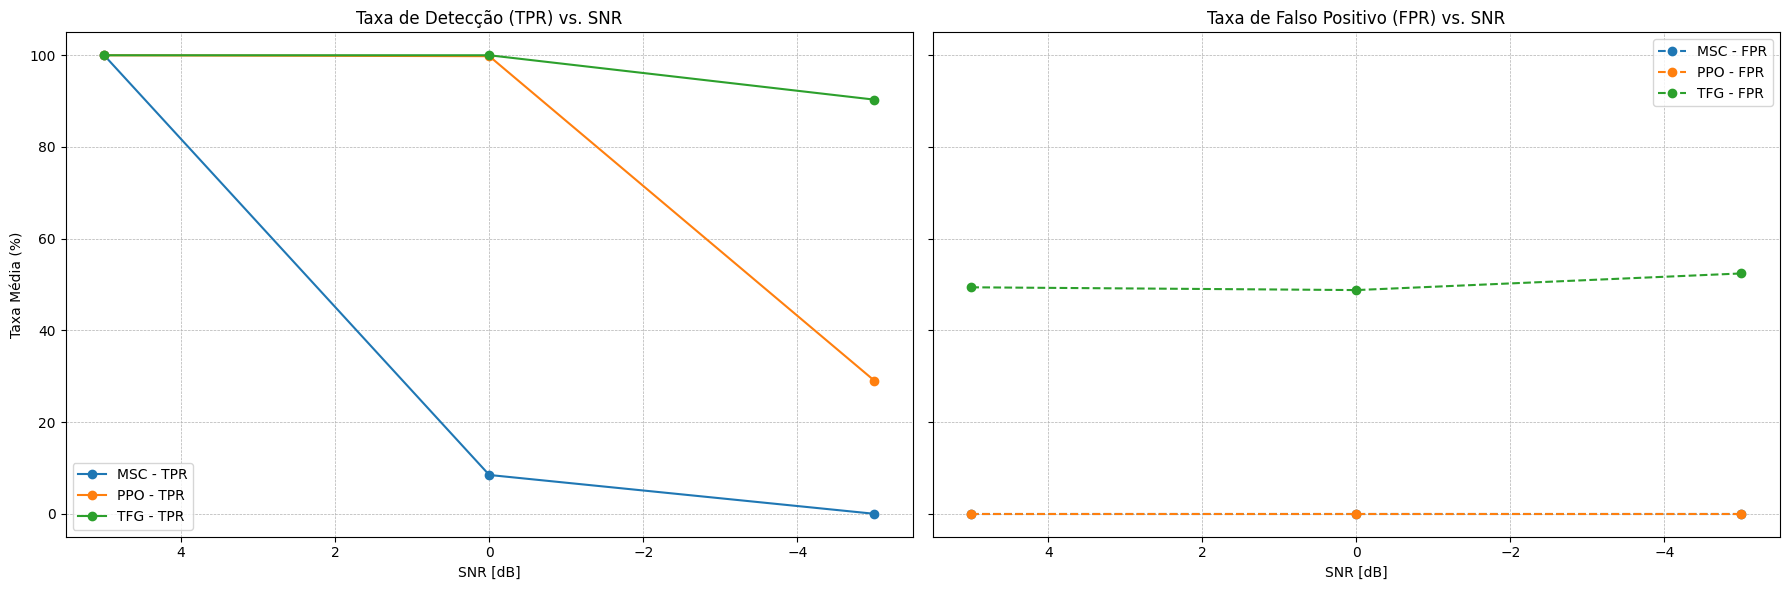

In [2]:
# -*- coding: utf-8 -*-
"""
Notebook Refatorado v21 para Treinamento de Modelo PPO com Dados 4D e 3D.

Esta versão final adiciona robustez à carga de dados experimentais. Ela detecta
se os dados experimentais são 3D (trials, freqs, features) e, em caso afirmativo,
adiciona uma dimensão 'windows' de tamanho 1 para torná-los 4D. Isso garante
que tanto os dados simulados quanto os experimentais tenham um formato 4D consistente,
resolvendo o `ValueError` durante a fase de avaliação experimental.
"""

# %% [markdown]
# # Treinamento de Modelo PPO com Features Pré-Calculadas (v21)
#
# # Este notebook treina um modelo PPO e lida de forma robusta com dados de simulação (4D) e experimentais (3D), garantindo a consistência do formato.

# %% [code]
# Importações essenciais
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import matplotlib.pyplot as plt
import h5py
import warnings
import re
from datetime import datetime

# Ignorar alguns avisos comuns para manter a saída limpa
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice.")


# %% [markdown]
# ## Parâmetros de Controle

# %% [code]
# #####################################################################
# MODO DE EXECUÇÃO E PARÂMETROS GLOBAIS
# #####################################################################
DRY_RUN = True # Mude para False para uma execução completa

if DRY_RUN:
    print("--- EXECUTANDO EM MODO DRY RUN (TESTE RÁPIDO) ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 2500, 1000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 5, 10
else:
    print("--- EXECUTANDO EM MODO COMPLETO ---")
    TOTAL_TIMESTEPS_TREINO, EVAL_SIM_TIMESTEPS = 25000, 5000
    VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ = 1, 25, 50

# #####################################################################
# CAMINHOS E CONSTANTES
# #####################################################################
FEATURE_NAMES = ['MSC', 'CSM', 'TFG', 'TFL', 'SNR_meas', 'MAG_freq', 'PHI_freq']
NUM_RAW_FEATURES = len(FEATURE_NAMES)
NUM_SIGNAL_FREQS = 8 # Número de frequências que contêm sinal
MODELS_TO_EVALUATE = ['PPO', 'MSC', 'TFG'] # Modelos a serem incluídos na avaliação

HDF5_SIMULATED_FILEPATH = '../data/train_v4.hdf5'
EXPERIMENTAL_FEATURES_FILE = '../data/experimental_features.hdf5'


# %% [markdown]
# ## Carga e Preparação dos Dados (HDF5)

# %% [code]
def load_and_adapt_hdf5_data(sim_path, exp_path):
    """
    Carrega dados HDF5 e garante que todos os datasets de saída tenham o formato 4D
    (trials, freqs, windows, features).
    """
    c_states_simulado = {}
    c_states_experimental = {}

    print(f"Carregando dados simulados de: {sim_path}")
    try:
        with h5py.File(sim_path, 'r') as f:
            snr_keys = sorted([key for key in f.keys() if 'snr' in key], key=lambda x: float(x.split('_')[1]))
            for key in snr_keys:
                snr_val = float(key.split('_')[1])
                data_4d = f[key]['metrics'][:]
                c_states_simulado[snr_val] = data_4d.transpose(0, 2, 1, 3)
                print(f"  - Carregado SNR {snr_val}: {c_states_simulado[snr_val].shape}")

    except FileNotFoundError:
        print(f"Aviso: Arquivo de dados simulados '{sim_path}' não encontrado. Treinamento será pulado.")
    except Exception as e:
        print(f"Erro ao carregar dados simulados: {e}")


    print(f"\nCarregando dados experimentais de: {exp_path}")
    try:
        with h5py.File(exp_path, 'r') as f:
            temp_experimental_data = {}
            for volunteer in f.keys():
                for intensity_key in f[volunteer].keys():
                    intensity_val_match = re.search(r'(\d+)', intensity_key)
                    if not intensity_val_match: continue
                    intensity_val = int(intensity_val_match.group(1))
                    data = f[volunteer][intensity_key]['metrics'][:]
                    if intensity_val in temp_experimental_data:
                        temp_experimental_data[intensity_val].append(data)
                    else:
                        temp_experimental_data[intensity_val] = [data]

            for intensity, data_list in temp_experimental_data.items():
                combined_data = np.concatenate(data_list, axis=0)
                
                # #####################################################################
                # CORREÇÃO: Garante que os dados experimentais também sejam 4D
                # #####################################################################
                if combined_data.ndim == 3:
                    # Adiciona a dimensão 'windows' que está faltando.
                    # Formato muda de (trials, freqs, features) para (trials, freqs, 1, features)
                    combined_data = np.expand_dims(combined_data, axis=2)
                # #####################################################################
                
                c_states_experimental[intensity] = combined_data
                print(f"  - Carregado e Formatado Intensidade {intensity} dB: {combined_data.shape}")

    except FileNotFoundError:
        print(f"Aviso: Arquivo de dados experimentais '{exp_path}' não encontrado. Avaliação experimental será pulada.")
    except Exception as e:
        print(f"Erro ao carregar dados experimentais: {e}")

    return c_states_simulado, c_states_experimental

c_states_simulado, c_states_experimental = load_and_adapt_hdf5_data(
    HDF5_SIMULATED_FILEPATH, EXPERIMENTAL_FEATURES_FILE
)

def clean_data_dict(data_dict):
    """Substitui NaNs e Infs por 0.0 para evitar erros no treinamento."""
    cleaned_dict = {}
    for key, array in data_dict.items():
        if np.isnan(array).any() or np.isinf(array).any():
            print(f"Aviso: Limpando valores inválidos para a chave '{key}'.")
            cleaned_dict[key] = np.nan_to_num(array, nan=0.0, posinf=0.0, neginf=0.0)
        else:
            cleaned_dict[key] = array
    return cleaned_dict

print("\nValidando e limpando dados...")
c_states_simulado = clean_data_dict(c_states_simulado)
c_states_experimental = clean_data_dict(c_states_experimental)
print("Validação completa.")


# %% [markdown]
# ## Ambientes Gymnasium Alinhados com Dados 4D

# %% [code]
class CustomLoggingCallback(BaseCallback):
    """Callback para logs customizados durante o treinamento."""
    def __init__(self, log_freq: int, verbose=0):
        super().__init__(verbose)
        self.log_freq, self.episode_count = log_freq, 0
    def _on_step(self) -> bool:
        if any(self.locals["dones"]):
            self.episode_count += 1
            if self.episode_count % self.log_freq == 0 and self.logger.name_to_value:
                print(f"--- Logs da Biblioteca (Episódio {self.episode_count}) ---")
                for key, value in self.logger.name_to_value.items():
                    print(f"  {key}: {value:.4f}")
                print("---------------------------------------")
        return True

class SimTrainingEnv(gym.Env):
    """Ambiente de treinamento que usa os dados 4D pré-calculados."""
    def __init__(self, data, verbose_level=0, verbose_freq=10):
        super().__init__()
        self.data = data # Formato esperado: (trials, freqs, windows, features)
        self.verbose_level, self.verbose_freq = verbose_level, verbose_freq
        
        self.num_trials, self.num_steps, self.num_windows, self.num_features = data.shape
        self.episode_count = -1

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.num_features,), dtype=np.float32
        )
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.current_trial_idx = self.episode_count % self.num_trials
        self.current_step = 0
        self.current_trial_data = self.data[self.current_trial_idx, :, :, :]
        self.false_positives, self.true_positives = 0, 0
        return self._get_state(), {}

    def step(self, action):
        should_detect = self.current_step < NUM_SIGNAL_FREQS
        
        tp, fp, fn, tn = 0, 0, 0, 0
        if action == 1:
            if should_detect: self.true_positives += 1; tp = 1
            else: self.false_positives += 1; fp = 1
        else:
            if should_detect: fn = 1
            else: tn = 1
        
        reward = tp - fp 

        self.current_step += 1
        terminated = self.current_step >= self.num_steps
        info = {}

        if terminated:
            num_noise_freqs = self.num_steps - NUM_SIGNAL_FREQS
            tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
            fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
            
            reward = ((tp_rate / 100) ** 2) - ((fp_rate / 100) ** 2)
            
            info = {'tp_rate': round(tp_rate, 2), 'fp_rate': round(fp_rate, 2)}
            if self.verbose_level > 0 and self.episode_count % self.verbose_freq == 0:
                print(f"--- Resumo do Ambiente (Episódio {self.episode_count}) ---")
                print(f"  TPR Final: {info.get('tp_rate',0):.2f}%, FPR Final: {info.get('fp_rate',0):.2f}%, Recompensa Final: {reward:.2f}")

        return self._get_state(), reward, terminated, False, info

    def _get_state(self):
        if self.current_step >= self.num_steps:
            return np.zeros(self.num_features, dtype=np.float32)
        return self.current_trial_data[self.current_step, -1, :]

class ExpEvaluationEnv(gym.Env):
    """Ambiente de avaliação que aceita dados 4D consistentes."""
    def __init__(self, data):
        super().__init__()
        self.data = data # Formato esperado: (trials, freqs, windows, features)
        self.num_trials, self.num_steps, self.num_windows, self.num_features = data.shape
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.num_features,), dtype=np.float32
        )
        self.current_trial_idx = -1
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_trial_idx = (self.current_trial_idx + 1) % self.num_trials
        self.current_trial_data = self.data[self.current_trial_idx]
        self.current_step, self.true_positives, self.false_positives = 0, 0, 0
        return self._get_state(), self._get_info()

    def step(self, action):
        should_detect = self.current_step < NUM_SIGNAL_FREQS
        if action == 1:
            if should_detect: self.true_positives += 1
            else: self.false_positives += 1
        
        self.current_step += 1
        terminated = self.current_step >= self.num_steps
        reward = 1
        
        info = self._get_info() if terminated else {}
        return self._get_state(), reward, terminated, False, info

    def _get_state(self):
        if self.current_step >= self.num_steps:
            return np.zeros(self.num_features, dtype=np.float32)
        return self.current_trial_data[self.current_step, -1, :]

    def _get_info(self):
        num_noise_freqs = self.num_steps - NUM_SIGNAL_FREQS
        tp_rate = 100 * self.true_positives / NUM_SIGNAL_FREQS if NUM_SIGNAL_FREQS > 0 else 0
        fp_rate = 100 * self.false_positives / num_noise_freqs if num_noise_freqs > 0 else 0
        return {'tp_rate': tp_rate, 'fp_rate': fp_rate}


# %% [markdown]
# # 1. Treinamento do Modelo PPO
# %% [code]
def train_ppo_model(policy, data, timesteps, model_name, v_level, v_freq, log_freq):
    print("--- Treinando modelo PPO ---")
    env = DummyVecEnv([lambda: SimTrainingEnv(data, v_level, v_freq)])
    policy_kwargs = dict(activation_fn=th.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))
    model = PPO(policy, env, verbose=0, policy_kwargs=policy_kwargs, n_steps=2048)
    model.learn(total_timesteps=timesteps, callback=CustomLoggingCallback(log_freq=log_freq))
    model.save(model_name)
    print(f"Modelo salvo como {model_name}\n")

snr_treino = 0.0
if snr_treino in c_states_simulado:
    dados_treino = c_states_simulado[snr_treino]
    train_ppo_model('MlpPolicy', dados_treino, TOTAL_TIMESTEPS_TREINO, 'modelo_ppo.zip', VERBOSE_LEVEL, VERBOSE_FREQ, SB3_LOG_FREQ)
else:
    print(f"ERRO: SNR de treino {snr_treino} dB não encontrado. Pulando treinamento.")

# %% [markdown]
# # 2. Avaliação Unificada e Geração de Gráficos

# %% [code]
def run_evaluation_for_model(model_name, env, total_timesteps, ppo_model=None):
    """Executa a avaliação para um determinado modelo e ambiente."""
    tpr_list, fpr_list = [], []
    num_episodes = max(1, total_timesteps // env.num_steps)

    for _ in range(num_episodes):
        obs, _ = env.reset()
        terminated = False
        while not terminated:
            if model_name == 'PPO':
                action, _ = ppo_model.predict(obs, deterministic=True)
            elif model_name == 'MSC':
                # Lógica de exemplo para MSC: detecta se a média da feature MSC é alta
                msc_feature_index = FEATURE_NAMES.index('MSC')
                action = 1 if obs[msc_feature_index] > 0.6 else 0
            elif model_name == 'TFG':
                # Lógica de exemplo para TFG: detecta se a feature TFG é alta
                tfg_feature_index = FEATURE_NAMES.index('TFG')
                action = 1 if obs[tfg_feature_index] > 0.5 else 0
            
            obs, _, terminated, _, info = env.step(action)
            if terminated:
                if 'tp_rate' in info and not np.isnan(info['tp_rate']):
                    tpr_list.append(info['tp_rate'])
                    fpr_list.append(info['fp_rate'])
    
    if not tpr_list: return np.nan, np.nan
    return np.nanmean(tpr_list), np.nanmean(fpr_list)

def plot_results_from_hdf5(filename):
    """Lê os resultados de avaliação de um arquivo HDF5 e os plota."""
    print(f"\n--- Gerando gráficos a partir de {filename} ---")
    with h5py.File(filename, 'r') as hf:
        if "simulated" in hf:
            sim_group = hf["simulated"]
            models = list(sim_group.keys())
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

            for model_name in models:
                if "tpr" in sim_group[model_name]:
                    snrs_str = sorted(sim_group[f'{model_name}/tpr'].keys(), key=float, reverse=True)
                    snrs_num = [float(s) for s in snrs_str]
                    tpr_values = [sim_group[f'{model_name}/tpr/{s}'][()] for s in snrs_str]
                    ax1.plot(snrs_num, tpr_values, 'o-', label=f'{model_name} - TPR')

                if "fpr" in sim_group[model_name]:
                    snrs_str = sorted(sim_group[f'{model_name}/fpr'].keys(), key=float, reverse=True)
                    snrs_num = [float(s) for s in snrs_str]
                    fpr_values = [sim_group[f'{model_name}/fpr/{s}'][()] for s in snrs_str]
                    ax2.plot(snrs_num, fpr_values, 'o--', label=f'{model_name} - FPR')

            ax1.set_title('Taxa de Detecção (TPR) vs. SNR'); ax1.set_xlabel('SNR [dB]'); ax1.set_ylabel('Taxa Média (%)')
            ax1.grid(True, which='both', linestyle='--', linewidth=0.5); ax1.legend(); ax1.invert_xaxis()
            ax2.set_title('Taxa de Falso Positivo (FPR) vs. SNR'); ax2.set_xlabel('SNR [dB]')
            ax2.grid(True, which='both', linestyle='--', linewidth=0.5); ax2.legend(); ax2.invert_xaxis()

            plt.tight_layout()
            plt.savefig('performance_vs_snr_combined.png')
            print("\nGráfico 'performance_vs_snr_combined.png' foi salvo.")
            plt.show()
        else:
            print("Nenhum resultado de dados simulados encontrado no arquivo para plotar.")

# --- Bloco Principal de Avaliação ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f'results_run_{timestamp}.hdf5'
print(f"\n--- Iniciando Fase de Avaliação ---")
print(f"Resultados serão salvos em: {results_filename}")

try:
    model_ppo = PPO.load('modelo_ppo.zip')
except FileNotFoundError:
    print("Aviso: 'modelo_ppo.zip' não encontrado. PPO será pulado na avaliação.")
    model_ppo = None

with h5py.File(results_filename, 'w') as hf:
    # --- Avaliação em Dados SIMULADOS ---
    if c_states_simulado:
        print("\n--- Avaliando modelos em dados SIMULADOS ---")
        sim_group = hf.create_group("simulated")
        snr_list_eval = sorted(c_states_simulado.keys(), reverse=True)
        if DRY_RUN: snr_list_eval = [snr for snr in snr_list_eval if snr in [5.0, 0.0, -5.0]]

        for model_name in MODELS_TO_EVALUATE:
            print(f"  Avaliando modelo: {model_name}")
            if model_name == 'PPO' and not model_ppo:
                print("    - Pulando PPO (modelo não carregado).")
                continue
            
            model_group = sim_group.create_group(model_name)
            tpr_group = model_group.create_group("tpr")
            fpr_group = model_group.create_group("fpr")

            for snr in snr_list_eval:
                env_sim = SimTrainingEnv(c_states_simulado[snr])
                tpr, fpr = run_evaluation_for_model(model_name, env_sim, EVAL_SIM_TIMESTEPS, ppo_model=model_ppo)
                print(f"    - SNR {snr} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
                tpr_group.create_dataset(str(snr), data=tpr)
                fpr_group.create_dataset(str(snr), data=fpr)
    
    # --- Avaliação em Dados EXPERIMENTAIS ---
    if c_states_experimental:
        print("\n--- Avaliando modelos em dados EXPERIMENTAIS ---")
        exp_group = hf.create_group("experimental")
        intensidades_db_list = sorted(c_states_experimental.keys())
        if DRY_RUN: intensidades_db_list = [i for i in intensidades_db_list if i in [30, 70]]

        for model_name in MODELS_TO_EVALUATE:
            print(f"  Avaliando modelo: {model_name}")
            if model_name == 'PPO' and not model_ppo:
                print("    - Pulando PPO (modelo não carregado).")
                continue

            model_group = exp_group.create_group(model_name)
            tpr_group = model_group.create_group("tpr")
            fpr_group = model_group.create_group("fpr")
            
            for intensidade in intensidades_db_list:
                dados_exp = c_states_experimental[intensidade]
                if dados_exp.shape[0] > 0:
                    env_exp = ExpEvaluationEnv(dados_exp)
                    # Para avaliação experimental, total_timesteps = número de trials * número de steps/trial
                    num_total_steps = dados_exp.shape[0] * dados_exp.shape[1]
                    tpr, fpr = run_evaluation_for_model(model_name, env_exp, num_total_steps, ppo_model=model_ppo)
                    print(f"    - Intensidade {intensidade} dB -> TPR: {tpr:.2f}%, FPR: {fpr:.2f}%")
                    tpr_group.create_dataset(str(intensidade), data=tpr)
                    fpr_group.create_dataset(str(intensidade), data=fpr)
                else:
                    print(f"    - Intensidade {intensidade} dB -> Sem dados para avaliação.")

# --- Geração de Gráficos a partir do arquivo salvo ---
plot_results_from_hdf5(results_filename)